In [1]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import re

import multiprocessing

# logging config
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# read data file: contains all text data concatenated into a single file
# with open('../data/AllCombined.txt', 'r', encoding='utf-8') as f:
#     contents = f.read()


# read data
df = pd.read_csv('../data/twitter/train.csv', encoding='latin-1', names=['target', 'ids', 'date', 'flag', 'user', 'text'])
contents = list(df['text'])[:50000]

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yjiah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yjiah\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yjiah\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# preprocessing:
# split text into sentences using fullstop
# tokenize the split sentences into words
# remove stopwords
# remove punctuation
# lemmatization

# split text into sentences by fullstop and lowercase everything up to 20000 sentences
sentences_lst = [tweet.lower() for tweet in contents]

# remove punctuation
sentences_lst_removed_punc = [re.sub(r'[^\w\s]', '', sentence) for sentence in sentences_lst]

# tokenize the split sentences into words
tokenized_sentences = [sentence.split() for sentence in sentences_lst_removed_punc]

# stopword removal
# stop_words = set(stopwords.words('english'))
# filtered_tokenized_sentences = [[word for word in sentence if word not in stop_words] for sentence in tokenized_sentences]

# lemmatization
# lemmatizer = WordNetLemmatizer()
# filtered_tokenized_sentences = [[lemmatizer.lemmatize(word) for word in sentence] for sentence in tokenized_sentences]

In [5]:
len(tokenized_sentences)

50000

In [6]:
# train the model
# change vector size, epochs, negative samples

models = {}
vector_sizes = [128, 256, 300]
epochs = [10, 15, 20]
negative_samples = [10, 15, 20]

# train the model using different parameters
for v in vector_sizes:
    for e in epochs:
        for ns in negative_samples:
            model = Word2Vec(
                tokenized_sentences,
                vector_size=v,
                window=5,
                min_count=1,
                sg=1,
                epochs=e,
                negative=ns,
                workers=12
            )

            # save each model in a dictionary, then pick best one later
            models[(v, e, ns)] = model

2025-08-17 10:55:57,804 : INFO : collecting all words and their counts
2025-08-17 10:55:57,806 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-08-17 10:55:57,847 : INFO : PROGRESS: at sentence #10000, processed 134601 words, keeping 17783 word types
2025-08-17 10:55:57,883 : INFO : PROGRESS: at sentence #20000, processed 267415 words, keeping 28936 word types
2025-08-17 10:55:57,915 : INFO : PROGRESS: at sentence #30000, processed 399736 words, keeping 38313 word types
2025-08-17 10:55:57,951 : INFO : PROGRESS: at sentence #40000, processed 532834 words, keeping 46941 word types
2025-08-17 10:55:57,985 : INFO : collected 55719 word types from a corpus of 666485 raw words and 50000 sentences
2025-08-17 10:55:57,985 : INFO : Creating a fresh vocabulary
2025-08-17 10:55:58,149 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 55719 unique words (100.00% of original 55719, drops 0)', 'datetime': '2025-08-17T10:55:58.149282', 'gensim': 

In [7]:
# save the trained models in case we need to use it again
for k in models.keys():
    vector_size, epochs, negative_samples = k
    models[k].save(f'./models/word2vec/skipgram_{vector_size}_{epochs}_{negative_samples}.model')

2025-08-17 11:24:41,724 : INFO : Word2Vec lifecycle event {'fname_or_handle': './models/word2vec/skipgram_128_10_10.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-08-17T11:24:41.724460', 'gensim': '4.3.3', 'python': '3.12.1 (tags/v3.12.1:2305ca5, Dec  7 2023, 22:03:25) [MSC v.1937 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'saving'}
2025-08-17 11:24:41,725 : INFO : not storing attribute cum_table
2025-08-17 11:24:41,811 : INFO : saved ./models/word2vec/skipgram_128_10_10.model
2025-08-17 11:24:41,811 : INFO : Word2Vec lifecycle event {'fname_or_handle': './models/word2vec/skipgram_128_10_15.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-08-17T11:24:41.811420', 'gensim': '4.3.3', 'python': '3.12.1 (tags/v3.12.1:2305ca5, Dec  7 2023, 22:03:25) [MSC v.1937 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'saving'}
2025-08-17 11:24:41,811 : INFO : not st

## Analysis

### Nearest Neighbours for selected words

In [11]:
selected_words = [
    'steak',
    'fight',
    'chemistry',
    'month',
    'news'
]

for params, model in models.items():
    vector_size, epochs, negative_samples = params
    print(f'Model parameters are: vector size = {vector_size}, epochs = {epochs}, negative samples = {negative_samples}')
    for word in selected_words:
        print(f'Word is: {word}')
        print(model.wv.most_similar(word))
        print("*" * 30)

    print("-" * 50)
    print()

Model parameters are: vector size = 128, epochs = 10, negative samples = 10
Word is: steak
[('tasting', 0.8721203804016113), ('dinky', 0.8687818646430969), ('sausages', 0.8673089742660522), ('weep', 0.8671755194664001), ('partybut', 0.8670915365219116), ('thong', 0.8662042021751404), ('premise', 0.8652415871620178), ('betfair', 0.8639827966690063), ('winery', 0.8605726957321167), ('rep', 0.860382616519928)]
******************************
Word is: fight
[('horror', 0.8201941251754761), ('awesomest', 0.8168988823890686), ('cutie', 0.8164651989936829), ('silva', 0.8162301182746887), ('kitties', 0.8145810961723328), ('sonny', 0.8112384080886841), ('zombies', 0.8112019896507263), ('chennai', 0.8088856935501099), ('ufc', 0.8074477314949036), ('jeff', 0.8057119250297546)]
******************************
Word is: chemistry
[('science', 0.8951855301856995), ('gcse', 0.8885318636894226), ('math', 0.8881132006645203), ('biology', 0.8818740248680115), ('alevel', 0.8778031468391418), ('maths', 0.875

Similar words sometimes do not make sense

Based on qualitative analysis on the chosen words, best model parameters are: vector size = 256, epochs = 15, negative samples = 15

### Visualization of PCA embedding space

In [12]:
model = models[(256, 15, 15)]

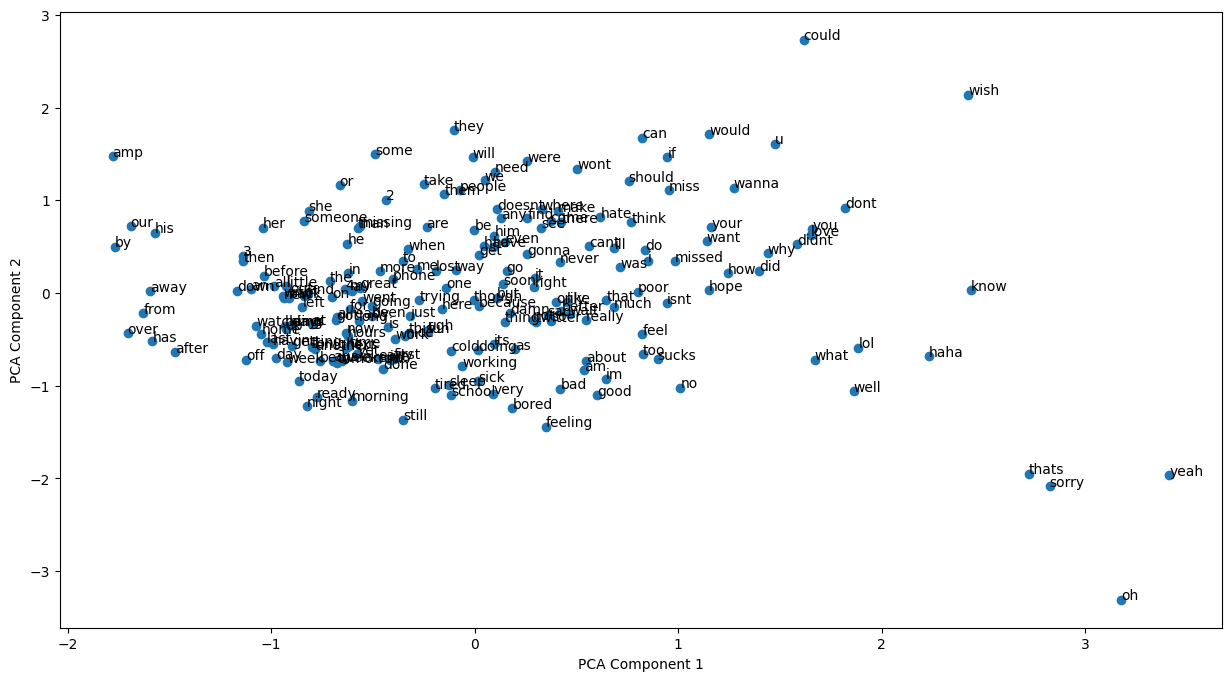

In [13]:
words = list(model.wv.index_to_key[0:200])
embeddings = model.wv[words]

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(15, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], marker='o')

for i, word in enumerate(words):
    plt.annotate(word, xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=10)


plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

We can see that some words like 'haha', 'lol' are clustered together, which seems right because they usually appear together